# Create ARC species input for thermo
This script creates an ARC species input given a yml or a species dictionary. It will check if a species is included in any thermo libraries, and exclude it in the generated input file.
Noted, the generated input may lack of necssary settings, and you need to add them before submit it as an ARC job.

### Necessary dependencies

In [1]:
import logging
import os

from rmgpy import settings
from rmgpy.data.rmg import RMGDatabase

from toolbox.species import read_spc_list_from_yml, write_spc_list_to_yml, \
                            read_spc_dict_from_path, spc_dict_to_spc_list
from toolbox.thermolib import find_thermo_libs, read_thermo_lib_by_path, \
                              merge_thermo_lib, draw_free_energies

%matplotlib inline
%load_ext autoreload
%autoreload 2

logger = logging.getLogger()
logger.setLevel(logging.INFO)

RDKit WARNING: [20:55:35] Enabling RDKit 2019.09.1 jupyter extensions


###  [OPTIONAL] Assign a log file to record all the changes

In [2]:
fh = logging.FileHandler('thermo_lib_tools.log', mode="a+")
fh.setLevel(logging.INFO)
fh.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s: %(message)s'))
logger.addHandler(fh)

### Load a RMG database instance
You may need to add some RMG built-in libraries for your purpose. The generated `thermo_database` will be used in the later section.

In [2]:
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = [],  # Can add other library if necessary
    kinetics_families = "default",
    reaction_libraries = [],
    kinetics_depositories = ['training'],
)

thermo_database = database.thermo

INFO:root:Loading thermodynamics group database from /Users/xiaorui/Apps/RMG-database/input/thermo/groups...
INFO:root:Loading transport library from GRI-Mech.py in /Users/xiaorui/Apps/RMG-database/input/transport/libraries...
INFO:root:Loading transport library from OneDMinN2.py in /Users/xiaorui/Apps/RMG-database/input/transport/libraries...
INFO:root:Loading transport library from NOx2018.py in /Users/xiaorui/Apps/RMG-database/input/transport/libraries...
INFO:root:Loading transport library from PrimaryTransportLibrary.py in /Users/xiaorui/Apps/RMG-database/input/transport/libraries...
INFO:root:Loading transport group database from /Users/xiaorui/Apps/RMG-database/input/transport/groups...
INFO:root:Loading frequencies group database from /Users/xiaorui/Apps/RMG-database/input/statmech/groups...
INFO:root:Loading Platts additivity group database from /Users/xiaorui/Apps/RMG-database/input/solvation/groups...


### [INPUT] Settings
- `work_dir` (str): indicate where your ARC jobs are located. Do not need to provide the full path to the file because the script will search for the thermolibrary.
- `source_file` (str): the full path to an ARC input file or species dictionary
- `save_path` (str): the full path save to the new ARC input file
- `disp` (bool): determine whether to display the molecule

In [4]:
work_dir = '../media/thermo library/check_species_in_thermo_library/'
source_file = '../media/thermo library/check_species_in_thermo_library/input.yml'
save_path = ''
disp = True

INFO:root:Find thermo library at ../media/thermo library/check_species_in_thermo_library/fake_arc_project/output/RMG libraries/thermo/BA.py
INFO:root:Loading thermodynamics library BA.py from ../media/thermo library/check_species_in_thermo_library/fake_arc_project/output/RMG libraries/thermo ...


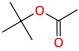

INFO:root:Writing the species tBA in to the yaml file


In [5]:
# Read the species list from yml_file
if '.yaml' in source_file or '.yml' in source_file:
    spc_list = read_spc_list_from_yml(source_file)
elif '.txt' in source_file:
    spc_dict = read_spc_dict_from_path(source_file)
    spc_list = spc_dict_to_spc_list(spc_dict)
    
# Get the thermo libraries under work_dir
thermo_lib_list = find_thermo_libs(work_dir)
for thermo_lib in thermo_lib_list:
    read_thermo_lib_by_path(thermo_lib, thermo_database)

# Find the species not contained in any of the library
not_include = []
for spc in spc_list:
    thermo = thermo_database.get_all_thermo_data(spc)
    if len(thermo) == 1:  # only GA value
        not_include.append(spc)
        if disp:
            display(spc)

# Write the species list containing unique species
# to a new yaml file'new_+[OLD_NAME]' 
write_spc_list_to_yml(not_include, save_path)